In [6]:
import numpy as np 
import pandas as pd 
import matplotlib.pyplot as plt 
import os 
import cv2 
from PIL import Image
from tensorflow import keras 
import tensorflow.keras.layers as k  
from IPython.display import HTML
from tensorflow.keras import models, layers
import tensorflow as tf

In [28]:
BATCH_SIZE = 32
IMAGE_SIZE = 256
CHANNELS=3
EPOCHS=50

In [29]:
dataset = tf.keras.preprocessing.image_dataset_from_directory(
    r"C:\Users\HP\Downloads\leafdata",
    seed=123,
    shuffle=True,
    image_size=(IMAGE_SIZE,IMAGE_SIZE),
    batch_size=BATCH_SIZE
)

Found 2152 files belonging to 3 classes.


In [30]:
class_names = dataset.class_names
class_names

['Early_blight_leaves', 'Healthy_leaves', 'Late_blight_leaves']

In [31]:
for image_batch, labels_batch in dataset.take(1):
    print(image_batch.shape)
    print(labels_batch.numpy())  #converting tensor to numpy to feed CNN
# print of one batch

(32, 256, 256, 3)
[2 2 2 0 0 0 0 0 2 2 2 2 0 2 0 2 2 2 0 2 0 2 0 0 2 0 0 1 2 2 0 0]


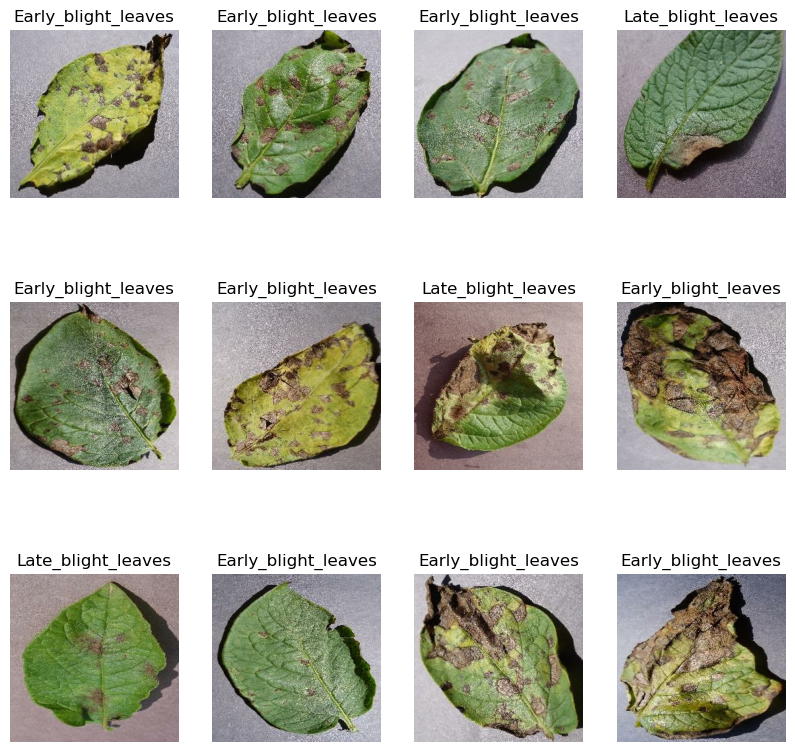

In [32]:
plt.figure(figsize=(10, 10))
for image_batch, labels_batch in dataset.take(1):
    for i in range(12):
        ax = plt.subplot(3, 4, i + 1)
        plt.imshow(image_batch[i].numpy().astype("uint8"))
        plt.title(class_names[labels_batch[i]])
        plt.axis("off")

In [33]:
len(dataset) #len is 68 
# 80%= Training 
# 10% = testing , 10% = validation #after each epoch we do validation on this data
# after validation - we will use the test data to check the accuracy


68

In [34]:

train_size = 0.8 #80% of traiining 
len(dataset)*train_size

54.400000000000006

In [35]:
train_ds = dataset.take(54)  # taking first 54 sample 
len(train_ds)

54

In [36]:
test_ds = dataset.skip(54) # this will give remaning data of test 
len(test_ds)

14

In [37]:
val_size=0.1 # getting val size 
len(dataset)*val_size

6.800000000000001

In [38]:
val_ds = test_ds.take(6) # validation data 
len(val_ds)

6

In [39]:
test_ds = test_ds.skip(6) #test data
len(test_ds)

8

In [40]:
def get_dataset_partitions_tf(ds, train_split=0.8, val_split=0.1, test_split=0.1, shuffle=True, shuffle_size=10000):
    assert (train_split + test_split + val_split) == 1
    
    ds_size = len(ds)
    
    if shuffle: #shuffle of data is happening before train test split 
        ds = ds.shuffle(shuffle_size, seed=12)
    
    train_size = int(train_split * ds_size)
    val_size = int(val_split * ds_size)
    
    train_ds = ds.take(train_size)    
    val_ds = ds.skip(train_size).take(val_size)
    test_ds = ds.skip(train_size).skip(val_size)
    
    return train_ds, val_ds, test_ds

In [41]:
train_ds, val_ds, test_ds = get_dataset_partitions_tf(dataset)

In [42]:
train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE) #prefetch - if cpu is busy training prefetch will load next batch which will improve the accuracy 
val_ds = val_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)  # cache wildo smoothly work of gpu and cpu 
test_ds = test_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)

In [43]:
resize_and_rescale = tf.keras.Sequential([ # resize the image if any image is not 256x256
  layers.Resizing(IMAGE_SIZE, IMAGE_SIZE),
  layers.Rescaling(1./255), 
])

In [44]:
data_augmentation = tf.keras.Sequential([  #Some more Preprocessing 
  layers.RandomFlip("horizontal_and_vertical"),
  layers.RandomRotation(0.2),
])

In [45]:
train_ds = train_ds.map(
    lambda x, y: (data_augmentation(x, training=True), y)
).prefetch(buffer_size=tf.data.AUTOTUNE)

In [46]:
from tensorflow.keras import layers, models

input_shape = (IMAGE_SIZE, IMAGE_SIZE, CHANNELS)
n_classes = 3

model = models.Sequential([
    tf.keras.layers.Input(shape=input_shape),
    resize_and_rescale,
    layers.Conv2D(32, kernel_size=(3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64, kernel_size=(3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64, kernel_size=(3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64, kernel_size=(3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64, kernel_size=(3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Flatten(),
    layers.Dense(64, activation='relu'),
    layers.Dense(n_classes, activation='softmax'),
])

model.summary()


Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ sequential (Sequential)         │ (None, 256, 256, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d (Conv2D)                 │ (None, 254, 254, 32)   │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 127, 127, 32)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 125, 125, 64)   │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 62, 62, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 60, 60, 64)     │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 30, 30, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_3 (Conv2D)               │ (None, 28, 28, 64)     │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_3 (MaxPooling2D)  │ (None, 14, 14, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_4 (Conv2D)               │ (None, 12, 12, 64)     │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_4 (MaxPooling2D)  │ (None, 6, 6, 64)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 2304)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 64)             │       147,520 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 3)              │           195 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 277,891 (1.06 MB)

 Trainable params: 277,891 (1.06 MB)

 Non-trainable params: 0 (0.00 B)

In [47]:
model.summary()

Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ sequential (Sequential)         │ (None, 256, 256, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d (Conv2D)                 │ (None, 254, 254, 32)   │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 127, 127, 32)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 125, 125, 64)   │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 62, 62, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 60, 60, 64)     │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 30, 30, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_3 (Conv2D)               │ (None, 28, 28, 64)     │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_3 (MaxPooling2D)  │ (None, 14, 14, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_4 (Conv2D)               │ (None, 12, 12, 64)     │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_4 (MaxPooling2D)  │ (None, 6, 6, 64)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 2304)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 64)             │       147,520 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 3)              │           195 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 277,891 (1.06 MB)

 Trainable params: 277,891 (1.06 MB)

 Non-trainable params: 0 (0.00 B)

In [48]:
model.compile(
    optimizer='adam',
    loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False),
    metrics=['accuracy']
) # compile the code using famous optimizer ADAM 

In [49]:
history = model.fit(
    train_ds,
    batch_size=BATCH_SIZE,
    validation_data=val_ds,
    verbose=1,
    epochs=50,
)

Epoch 1/50
54/54 ━━━━━━━━━━━━━━━━━━━━ 48s 797ms/step - accuracy: 0.4552 - loss: 0.9551 - val_accuracy: 0.7240 - val_loss: 0.6566
Epoch 2/50
54/54 ━━━━━━━━━━━━━━━━━━━━ 41s 744ms/step - accuracy: 0.7695 - loss: 0.5541 - val_accuracy: 0.8073 - val_loss: 0.5427
Epoch 3/50
54/54 ━━━━━━━━━━━━━━━━━━━━ 40s 729ms/step - accuracy: 0.8480 - loss: 0.4134 - val_accuracy: 0.8750 - val_loss: 0.3076
Epoch 4/50
54/54 ━━━━━━━━━━━━━━━━━━━━ 40s 726ms/step - accuracy: 0.9108 - loss: 0.2351 - val_accuracy: 0.8333 - val_loss: 0.3841
Epoch 5/50
54/54 ━━━━━━━━━━━━━━━━━━━━ 41s 749ms/step - accuracy: 0.9162 - loss: 0.2029 - val_accuracy: 0.9167 - val_loss: 0.1989
Epoch 6/50
54/54 ━━━━━━━━━━━━━━━━━━━━ 41s 756ms/step - accuracy: 0.9355 - loss: 0.1655 - val_accuracy: 0.8594 - val_loss: 0.3561
Epoch 7/50
54/54 ━━━━━━━━━━━━━━━━━━━━ 41s 751ms/step - accuracy: 0.9303 - loss: 0.1782 - val_accuracy: 0.9323 - val_loss: 0.1727
Epoch 8/50
54/54 ━━━━━━━━━━━━━━━━━━━━ 42s 781ms/step - accuracy: 0.9451 - loss: 0.1416 - val_accu

In [50]:
scores = model.evaluate(test_ds)

8/8 ━━━━━━━━━━━━━━━━━━━━ 2s 126ms/step - accuracy: 0.9953 - loss: 0.0097


In [51]:
scores

[0.008631879463791847, 0.99609375]

In [52]:
history

In [53]:
history.params

{'verbose': 1, 'epochs': 50, 'steps': 54}

In [54]:
history.history.keys()

dict_keys(['accuracy', 'loss', 'val_accuracy', 'val_loss'])

In [55]:
type(history.history['loss'])

list

In [56]:
len(history.history['loss'])

50

In [57]:
history.history['loss'][:5]

[0.8718200325965881,
 0.5104182362556458,
 0.37770992517471313,
 0.2270810455083847,
 0.21818800270557404]

In [58]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

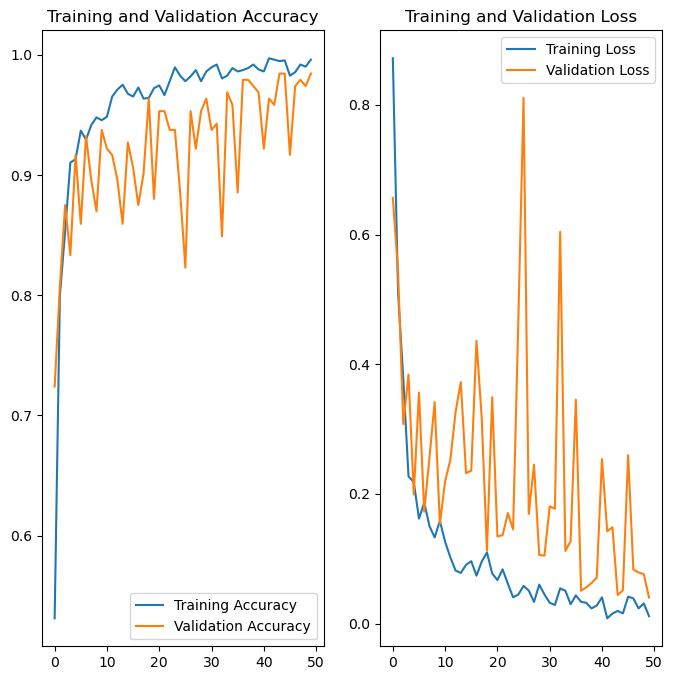

In [59]:
plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(range(EPOCHS), acc, label='Training Accuracy')
plt.plot(range(EPOCHS), val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(range(EPOCHS), loss, label='Training Loss')
plt.plot(range(EPOCHS), val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

first image to predict
actual label: Late_blight_leaves
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 235ms/step
predicted label: Late_blight_leaves


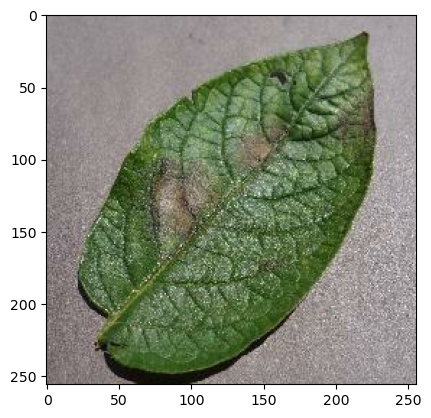

In [60]:

import numpy as np
for images_batch, labels_batch in test_ds.take(1):
    
    first_image = images_batch[0].numpy().astype('uint8') #first image 
    first_label = labels_batch[0].numpy()
    
    print("first image to predict")
    plt.imshow(first_image)
    print("actual label:",class_names[first_label])
    
    batch_prediction = model.predict(images_batch)
    print("predicted label:",class_names[np.argmax(batch_prediction[0])])

In [61]:
def predict(model, img):
    img_array = tf.keras.preprocessing.image.img_to_array(images[i].numpy())
    img_array = tf.expand_dims(img_array, 0)

    predictions = model.predict(img_array)

    predicted_class = class_names[np.argmax(predictions[0])]
    confidence = round(100 * (np.max(predictions[0])), 2)
    return predicted_class, confidence

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 110ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step


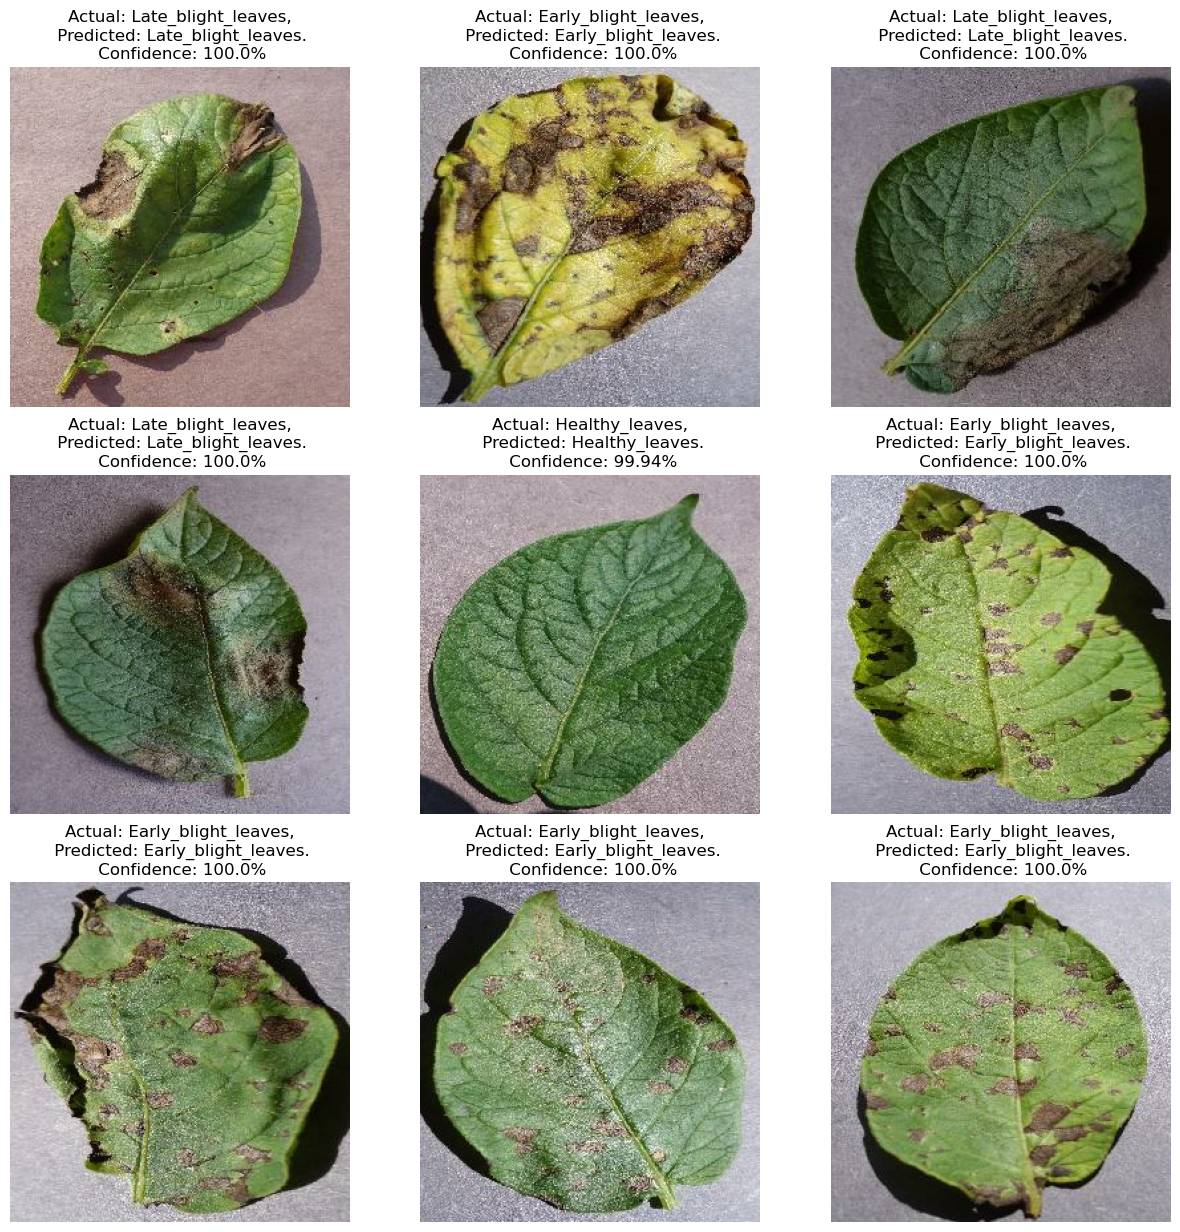

In [62]:
plt.figure(figsize=(15, 15))
for images, labels in test_ds.take(1):
    for i in range(9):
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(images[i].numpy().astype("uint8"))
        
        predicted_class, confidence = predict(model, images[i].numpy())
        actual_class = class_names[labels[i]] 
        
        plt.title(f"Actual: {actual_class},\n Predicted: {predicted_class}.%")
        
        plt.axis("off")

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, random_split
from torchvision import datasets, models, transforms
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score, roc_curve, classification_report

# Define data transformations
transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
])

# Load dataset
dataset = datasets.ImageFolder(r"C:\Users\HP\Downloads\leafdata", transform=transform)
train_size = int(0.8 * len(dataset))
val_size = len(dataset) - train_size
train_dataset, val_dataset = random_split(dataset, [train_size, val_size])
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False)

# Define model architectures
class CustomCNN(nn.Module):
    def __init__(self, num_classes):
        super(CustomCNN, self).__init__()
        self.conv1 = nn.Conv2d(3, 32, kernel_size=3, stride=1, padding=1)
        self.conv2 = nn.Conv2d(32, 64, kernel_size=3, stride=1, padding=1)
        self.fc1 = nn.Linear(64 * 56 * 56, 256)
        self.fc2 = nn.Linear(256, num_classes)
        self.relu = nn.ReLU()
        self.pool = nn.MaxPool2d(2, 2)
        self.dropout = nn.Dropout(0.5)
    
    def forward(self, x):
        x = self.pool(self.relu(self.conv1(x)))
        x = self.pool(self.relu(self.conv2(x)))
        x = torch.flatten(x, 1)
        x = self.relu(self.fc1(x))
        x = self.dropout(x)
        x = self.fc2(x)
        return x

# Load pre-trained VGG16 model
vgg16 = models.vgg16(pretrained=True)
for param in vgg16.features.parameters():
    param.requires_grad = False
vgg16.classifier[6] = nn.Linear(4096, len(dataset.classes))

# Define training function
def train_model(model, train_loader, val_loader, criterion, optimizer, num_epochs=10):
    train_acc, val_acc, train_loss, val_loss = [], [], [], []
    for epoch in range(num_epochs):
        model.train()
        running_loss, correct = 0.0, 0
        for images, labels in train_loader:
            optimizer.zero_grad()
            outputs = model(images)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            running_loss += loss.item()
            correct += (outputs.argmax(1) == labels).sum().item()
        train_acc.append(correct / len(train_loader.dataset))
        train_loss.append(running_loss / len(train_loader))
        
        # Validation
        model.eval()
        running_loss, correct = 0.0, 0
        with torch.no_grad():
            for images, labels in val_loader:
                outputs = model(images)
                loss = criterion(outputs, labels)
                running_loss += loss.item()
                correct += (outputs.argmax(1) == labels).sum().item()
        val_acc.append(correct / len(val_loader.dataset))
        val_loss.append(running_loss / len(val_loader))
    
    return train_acc, val_acc, train_loss, val_loss

# Training VGG16
vgg16_criterion = nn.CrossEntropyLoss()
vgg16_optimizer = optim.Adam(vgg16.parameters(), lr=0.001)
vgg16_results = train_model(vgg16, train_loader, val_loader, vgg16_criterion, vgg16_optimizer, num_epochs=10)

# Training Custom CNN
custom_cnn = CustomCNN(num_classes=len(dataset.classes))
custom_criterion = nn.CrossEntropyLoss()
custom_optimizer = optim.Adam(custom_cnn.parameters(), lr=0.001)
custom_results = train_model(custom_cnn, train_loader, val_loader, custom_criterion, custom_optimizer, num_epochs=10)

# Plot training vs validation accuracy/loss
def plot_metrics(train_acc, val_acc, train_loss, val_loss, model_name):
    plt.figure(figsize=(12, 5))
    plt.subplot(1, 2, 1)
    plt.plot(train_acc, label='Train Accuracy')
    plt.plot(val_acc, label='Validation Accuracy')
    plt.title(f'{model_name} Accuracy')
    plt.legend()

    plt.subplot(1, 2, 2)
    plt.plot(train_loss, label='Train Loss')
    plt.plot(val_loss, label='Validation Loss')
    plt.title(f'{model_name} Loss')
    plt.legend()
    plt.show()

plot_metrics(*vgg16_results, "VGG16")
plot_metrics(*custom_results, "Custom CNN")

# Evaluate performance

def evaluate_model(model, dataloader):
    y_true, y_pred = [], []
    model.eval()
    with torch.no_grad():
        for images, labels in dataloader:
            outputs = model(images)
            _, preds = torch.max(outputs, 1)
            y_true.extend(labels.numpy())
            y_pred.extend(preds.numpy())
    print(classification_report(y_true, y_pred))
    print("AUC Score:", roc_auc_score(y_true, y_pred, multi_class='ovr'))

# Evaluate both models
evaluate_model(vgg16, val_loader)
evaluate_model(custom_cnn, val_loader)





C:\Users\HP\AppData\Roaming\Python\Python311\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
C:\Users\HP\AppData\Roaming\Python\Python311\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=VGG16_Weights.IMAGENET1K_V1`. You can also use `weights=VGG16_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


In [180]:
from tensorflow.keras.models import save_model

save_model(model, r'C:\Users\HP\Downloads\Models\my_model.keras')
print(r"Model saved as 'C:\Users\HP\Downloads\Models\my_model.keras'")



Model saved as 'C:\Users\HP\Downloads\Models\my_model.keras'


In [10]:
 
from tensorflow.keras.models import load_model

# Load your trained model
model = load_model(r'C:\Users\HP\Downloads\Models\my_model.h5')  # Replace with the path to your model

def predict_single_image(image_path):
    """
    Load a single image, preprocess it, and make a prediction.
    """
    # Load the image
    image = cv2.imread(image_path)
    if image is None:
        print(f"Error: Unable to load image at {image_path}")
        return

    # Preprocess the image to match the model's input size
    # Replace (224, 224) with your model's expected input size
    input_size = (224, 224)
    image_resized = cv2.resize(image, input_size)
    image_normalized = image_resized / 255.0  # Normalize if your model requires it
    image_batch = np.expand_dims(image_normalized, axis=0)  # Add batch dimension

    # Predict using the model
    prediction = model.predict(image_batch)

    # Process the prediction
    # For example, if it's classification:
    predicted_class = np.argmax(prediction, axis=-1)
    confidence = np.max(prediction)

    print(f"Predicted Class: {predicted_class[0]}, Confidence: {confidence:.2f}")

# Path to your image
image_path = r'C:\Users\HP\Downloads\lb_image_model.JPG'  # Replace with the path to your image
predict_single_image(image_path)


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 232ms/step
Predicted Class: 0, Confidence: 0.75
